# Einleitung
Dieses Jupyter Notebook demonstriert, wie aufbereitete Daten des Historischen Grundbuchs der Stadt Basel durchsucht werden können.

Bemerkung: Je nach Suche, Suchbegriff und Suchzeitraum kann die Suche einige Zeit dauern.

TODO
- Weitere Informationen zum HGB?
- Weitere Informationen zum zur Verfügung gestellten Datensatz. Welche Daten sind vorhanden, Aussage über Genauigkeit, Datenschema,...

# Importiere Packages
Importiere für dieses Skript notwendige Funktionen.

In [1]:
import zipfile
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from pyproj import Transformer
from ipyleaflet import Map, WMSLayer, Circle, Popup
import ipywidgets as widgets
from thefuzz import fuzz

# Entpacke Datengrundlage
Entpacke für die Suche verwendete Datengrundlage.

In [2]:
# Datasource for the search.
FILEPATH_DATASOURCE = './hgb_corpus_24_07_26_inline_full_updated.zip'

# Unzip the file.
with zipfile.ZipFile(FILEPATH_DATASOURCE, 'r') as myzip:
    myzip.extractall('.')

# Update the filepath.
FILEPATH_DATASOURCE = os.path.splitext(FILEPATH_DATASOURCE)[0] + '.xml'

# Freitextsuche
Beispiel: Suche nach dem Begriff "Wysung" in Paragraphen von Dokumenten im Zeitraum 1550 – 1600.

## Definiere Suchparameter
Festlegen der gewünschten Parameter für die Suche.

In [3]:
# Set search word.
SEARCH_KEYWORD = 'Wysung'

# Define search period.
YEAR_MIN = 1550
YEAR_MAX = 1600

## Suche ausführen
Durchführung der Freitextsuche.

In [4]:
# Load xml file.
context = ET.iterparse(FILEPATH_DATASOURCE, events=('start', 'end'))

# Create an empty dataframe to store the search results.
results = pd.DataFrame(
    columns=['id', 'house', 'coord_x', 'coord_y',
             'pages', 'year', 'text', 'imagelinks'
             ]
    )

# Iterate over each element.
collection_element = None
for event, elem in context:

    # The start event is triggered when the parser encounters the opening tag of an element.
    if event == 'start' and elem.tag == 'Collection':
            
        # Store current collection element.
        collection_element = elem
    
    # The end event is triggered when the parser encounters the closing tag of an element.
    elif event == 'end' and elem.tag == 'Document':
            
        # Get the header element.
        header = elem.find('Header')
        
        # Determine the year of the document.
        year = int(header.get('year'))

        # Skip the document if not in desired search period.
        if year < YEAR_MIN or year > YEAR_MAX:
            continue

        # Get the text attribute.
        text = header.get('text')

        # Search for keyword in text.
        if SEARCH_KEYWORD in text:
        
            # Store selected elements in dataframe.
            results.loc[len(results)] = [
                collection_element.attrib['id'],
                collection_element.attrib['house'],
                collection_element.attrib['coord_x'],
                collection_element.attrib['coord_y'],
                header.get('pages'),
                year,
                text,
                header.get('imagelinks')
                ]

# Print the number of search results.
print(f'The keyword "{SEARCH_KEYWORD}" was found in {results.shape[0]} documents '
      f'in the period {YEAR_MIN} - {YEAR_MAX}.'
      )

The keyword "Wysung" was found in 26 documents in the period 1550 - 1600.


## Ergebnisse in Tabelle darstellen
Die Suchergebnisse werden in einer Tabelle dargestellt. Der Suchbegriff wird im Text vorgehoben und das zugehörige Digitalisat zur Verfügung gestellt.


In [5]:
# Reduce the table of results for the display. 
filtered_results = results[['id', 'house', 'pages', 'year', 'text', 'imagelinks']].copy()

# Define the integration of the images in the table.
def make_clickable_images(val):
    urls = val.split(" | ")
    img_tags = [f'<a href="{url}" target="_blank"><img src="{url}" width="100" /></a>' for url in urls]
    return " ".join(img_tags)
filtered_results['imagelinks'] = filtered_results['imagelinks'].apply(make_clickable_images)

# Highlight the search word.
def highlight_keyword(keyword, val):
    if keyword in val:
        return val.replace(f'{keyword}', f'<span style="color: red;">{keyword}</span>')
    return val
filtered_results['text'] = filtered_results['text'].apply(
    lambda x: highlight_keyword(SEARCH_KEYWORD, x)
    )

# Render the dataframe as HTML on show the table.
html = filtered_results.to_html(escape=False)
display(HTML(html))

,id,house,pages,year,text,imagelinks
0,HGB_1_024_074,Barfüsserplatz 35,29,1552,"Privat Urkunde.\nAmbrosi Dorn der Fischmacher, Burger zu Basel und\nMargreth sin eelich Wyb verkaufen dem Closter zu\nsant Lienhart zu Basel 10 sh. Gelts jerlichs Zinses von uff\nund abe irem Sashuse und Hofstatt sambt dem Höffli\ndarhinder, als das in der Statt Basel, oben an der Gär¬\nwer Gassen, zwischen dem Huss Grüneckh und\nRisen Hus gelegen und Herrnberg genant ist, zinst\njerlichs von wegen der Eigenschafft dem gemelten Kloster,\nvormols 2 ℔. Zinspfg, 2 Ring Brots zu Wysung und\n3sh. zu Erschatz, sodann zinset das Höffli in das Hus\nBabenberg 13 sh. und 4 Sabler Zinspfg. dem Closter Clingen,\ntal 1 ℔. Gelts, um 10℔. Stäbler.",
1,HGB_1_024_119,Barfüsserplatz 32,37,1577,"Hanns Lux Hagenbach, Schaffner und jnnamen der Presen,\nS. Peter Stift, hat Michel Böglins, Meigers zu Buschwyler,\nHus und Hofstatt by der Barfüssern, gegen Barfüssericht\nüber zu einer dem Hus Hudan, genannt Heinrich Betzen\nHus, andersyts neben dem Hus Pflatterin gelegen, versessener\nZinsen wegen, als der Presentz jährl. darab 10 sh. ein ring\nbrots zur Wysung und 2 ½ sh. zu Erschatz zinst wird,\ngefrönt.",
2,HGB_1_058_041,Freie Strasse Theil von 35 neben 33,"15, 16",1575,"Rathsurkunde.\nDer Rath bewilligt dem Burger Ambrosien Darmosen, wirt zu\ndem Wildenman in Basel in dara Köwin, siner ehelichen Husfrowen,\ndas solliche Herberg, doch it leger, dan ir beder Reben lang und so\nlang sie bede Wegemacht dieselb ir Herberg ze dem Wildenmann\neigener Person besitzen, hewonen, ein Herren Herberg sein, die\nwie andere Herren Würt bruchen und das sy desshalb nach Wysung unser\nerkhantin und gesetzten Ordnung ein zwey, oder dreyerleg wyn haben,\ndenselben Jren Gesten zutrinckhen, das Mal u. mit mehr das Pfenwert.\ngeben, u. dieselben Wyn, so sie inlegendt, noch der Ordmung sag, besigen\nlassen, und davon das Ambgelt bezalen, die Gest frenndtlichen u.\nbescheidenlichen hallten, allen utzen Gesindem liederlicher\nLüden, alls hemifegern, Schaffhonte Trägern u. derglychen\nnachtbarer noch gülltigen Personen sich entschlachen, die\nIm beherbergen mit uffneinen, sonders sachs fürweysen u. alls die [sep] obgemelte Her Herberg, u. Würtshafft sober, u. seg, wie Herren Würten\ngeburt u. intodt, Kallten sollen. falls die obgemelte bede Ehgemelt\ndie Herberg verlychen des verkaufen, so hat der Uebenchmar eine\nnam Bewilligung einzuhaler, was ihm von der den Glog, dentlich\nzu erklarmist.",
3,HGB_1_058_070,Freie Strasse 79,34,1573,"Privat Urkunde.\nChristen Murer der Schuchmacher des Rhatz zu Basel\nund Barbel Scholtmann syn Ehfrouw verkaufen Lien¬\nharten Schotmans 6 ℔. 5 sh. jerlichs Zinses von uff und ab\nirem Hus und Hofstat an der freigen Strass gelegen und\nSandt Jacobs Hus genant, einseit neben Herren Tantha\nleon Wurstysen, anderseit neben Samuel Wurstysen gelegen\nstost hinden an den Liechtenfelser Hoff, zinst dem Spittal\n10 sh. ein Ring Brot ze Wysung, der Presentz uff Burg 10sh.\nsonst ledig eigen, umb 125 ℔.",
4,HGB_1_122_060,Marktplatz 18,"5, 6",1555,"Schultheissenurkunde.\nJopp Schenckh, Burger zu Basell, und Cristiana Murerin\ngemet Roman, sie Gefrow, verkaufen Cristoffeln Fröndenberg\nfür sich selbs und Anastasia Schöttlin sine Eefrow, und\nGylgen Werenfels, beiden Krämern, Burgern zu Basell\ndas hus und hoffstatt sampt dem höfli und hindern\nhus, ouch dem Gedemlin darubendt mit aller Gerechtig¬\nseit und Zughördt als das im der Statt Basell an dem\nKornmerckt gegen dem Richthus über, ist ein Eckhus und\nneben dem hus zum Pfouwen glegen und stoßt hinden us\nnebend der Gandchen, gegen dem Kornmerckt Brunnen\nund Pfouwenberg genant ist, zinset järlichs von wegen der\nGygenschaft das hinder hus und höfflin allein der hohen\nStifft 3 1/2 Pfundt 7 Schilling gewonlicher Baßler Zinsshein\nund 4 Ring Brots zu Wysung und 5 Schilling zu Erschatz\nwan sich die Handt verwandelt, zinset dan das [sep] gantz hus järlich dem Brediger Kloster zu Ba-\nfell 32 Pfundt 4 Schilling amper Pfennigen

## Histogramm der Resultate über die Zeit
Die Verteilung der Suchresultate über den Suchzeitraum wird in einem Histogramm visualisiert.

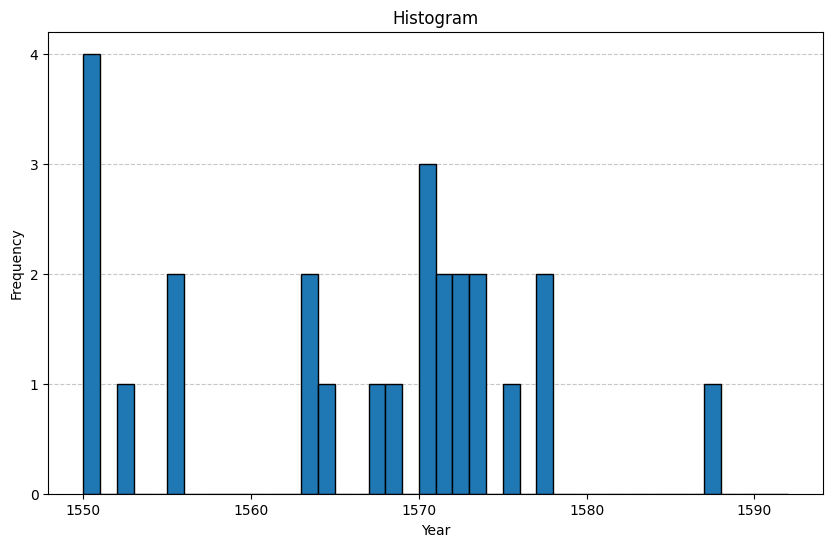

In [6]:
# Define the appearance of the histogram.
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(
    results['year'],
    bins=range(min(results['year']), max(results['year']), 1),
    edgecolor='black'
    )
plt.title('Histogram')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)
plt.yticks(np.arange(0, np.max(n) + 1, 1))

# Display the plot.
plt.show()

## Visualisiere Ergebnisse im Raum
Die Suchresultate werden als Punkte auf dem "Loeffel"-Plan dargestellt.

In [7]:
# Transform the coordinates of the search results.
def transform_coords(x, y):
    transformer = Transformer.from_crs(2056, 4326)
    return transformer.transform(x, y)
results['lat'], results['lon'] = zip(*results.apply(
    lambda row: transform_coords(row['coord_x'], row['coord_y']), axis=1
    ))

# Define the basemap.
wms = WMSLayer(
    url='https://wms.geo.bs.ch/',
    layers='HP_Uebersichtsplaene_Basel_Situationsplan1862',
    attribution='Geodaten Kanton Basel-Stadt'
)
m = Map(basemap=wms, center=(47.557, 7.595), zoom=14)

# Add the search results to the map.
for index, row in results.iterrows():
    
    # Create Circle.
    circle = Circle(location=(row['lat'], row['lon']),
                    radius=3,
                    color='blue',
                    fill_color='blue')
    
    # Add pop-up to display attributes of the circle.
    popup_content = f"""ID: {row['id']}<br>
    House: {row['house']}<br>
    Pages: {row['pages']}<br>
    Year: {row['year']}"""
    popup = Popup(location=(row['lat'], row['lon']), child=widgets.HTML(popup_content), close_button=True)
    circle.popup = popup

    # Add the circle to the map.
    m.add_layer(circle)

#  Display the map.
m

Map(center=[47.557, 7.595], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

## Suchresultate exportieren
Exportiere Suchergebnisse als Exceltabelle in Arbeitsverzeichnis.

In [8]:
results.to_excel('search_results.xlsx', index=False)
print('Search results were exported.')

Search results were exported.


# Fuzzy-Suche

Die "Fuzzy"-Suche ist eine fehlertolerante Suche.

Beispiel: Suche nach dem Begriff "wisung" (Standardschreibweise) in Paragraphen von Dokumenten im Zeitraum 1550 – 1600.

Mit dem "Verhältnis-Schwellenwert" wird definiert, wie ähnlich Suchresultate zum Suchbegriff sein sollen. Je kleiner dieser Wert, je mehr Treffer werden generiert.

TODO
- Standardschreibweise definieren

## Definiere Suchparameter

In [9]:
# Set search word.
SEARCH_KEYWORD = 'wisung'

# Define search period.
YEAR_MIN = 1550
YEAR_MAX = 1600

# Ratio threshold between 0 and 100.
RATIO_THRESHOLD = 80

## Suche ausführen

In [10]:
# Load xml file.
context = ET.iterparse(FILEPATH_DATASOURCE, events=('start', 'end'))

# Create an empty dataframe to store the search results.
results = pd.DataFrame(
    columns=['id', 'house', 'coord_x', 'coord_y',
             'pages', 'year', 'text', 'imagelinks',
             'ratio']
    )

# Iterate over each element.
collection_element = None
for event, elem in context:
    if event == 'start' and elem.tag == 'Collection':
            
        # Store current collection element.
        collection_element = elem
    
    elif event == 'end' and elem.tag == 'Document':
            
        # Get the header element.
        header = elem.find('Header')
        
        # Determine the year of the document.
        year = int(header.get('year'))

        # Skip the document if not in desired search period.
        if year < YEAR_MIN or year > YEAR_MAX:
            continue

        # Get the text attribute.
        text = header.get('text')

        # Perform a fuzzy search.
        ratio = fuzz.partial_token_sort_ratio(SEARCH_KEYWORD, text)

        # Search for keyword in text.
        if ratio >= RATIO_THRESHOLD:
        
            # Store selected elements in dataframe.
            results.loc[len(results)] = [
                collection_element.attrib['id'],
                collection_element.attrib['house'],
                collection_element.attrib['coord_x'],
                collection_element.attrib['coord_y'],
                header.get('pages'),
                year,
                text,
                header.get('imagelinks'),
                ratio
                ]

# Print the number of search results.
print(f'The fuzzy search with the search term "{SEARCH_KEYWORD}" '
      f'found {results.shape[0]} of documents in the period between '
      f'{YEAR_MIN} and {YEAR_MAX} with a ratio of {RATIO_THRESHOLD} or more.'
      )

The fuzzy search with the search term "wisung" found 389 of documents in the period between 1550 and 1600 with a ratio of 80 or more.


# Suche nach Entität
Annotationssuche nach einer Entität.


Beispiel: Suche nach dem Begriff "Fischer" in Paragraphen von Dokumenten im Zeitraum 1550 – 1600.


TODO
- Definieren, was eine Entität ist.
- Parameter MENTION_SUBTYPE definieren.
- Mögliche Werte für MENTION_SUBTYPE definieren.
- Ev. Normalisierung definieren


## Suchparameter

In [11]:
# Set search word.
SEARCH_KEYWORD = 'Fischer'

# Define the mention subtype.
MENTION_SUBTYPE = 'occ'

# Define search period.
YEAR_MIN = 1550
YEAR_MAX = 1600

## Suche ausführen

In [12]:
# Load xml file.
context = ET.iterparse(FILEPATH_DATASOURCE, events=('start', 'end'))

# Create an empty dataframe to store the search results.
results = pd.DataFrame(
    columns=['id', 'house', 'coord_x', 'coord_y',
             'pages', 'year', 'text', 'imagelinks',
             'head', 'confidence'
             ]
    )

# Iterate over each element.
collection_element = None
for event, elem in context:
    if event == 'start' and elem.tag == 'Collection':
            
        # Store current collection element.
        collection_element = elem
    
    elif event == 'end' and elem.tag == 'Document':
            
        # Get the header element.
        header = elem.find('Header')
        
        # Determine the year of the document.
        year = int(header.get('year'))

        # Skip the document if not in desired search period.
        if year < YEAR_MIN or year > YEAR_MAX:
            continue
        
        # Iterate over all attributes of the document.
        for attribute in elem.findall('.//Attribute'):
            if attribute.attrib.get('mention_subtype') == MENTION_SUBTYPE:
                
                # Get the header text.
                head = attribute.find('.//Head')
                head_text = head.text

                # Search for keyword in text.
                if head_text and SEARCH_KEYWORD in head_text:
                
                    # Store selected elements in dataframe.
                    results.loc[len(results)] = [
                        collection_element.attrib['id'],
                        collection_element.attrib['house'],
                        collection_element.attrib['coord_x'],
                        collection_element.attrib['coord_y'],
                        header.get('pages'),
                        year,
                        header.get('text'),
                        header.get('imagelinks'),
                        head_text,
                        attribute.attrib.get('confidence')
                        ]

# Print the number of search results.
print(f'The keyword "{SEARCH_KEYWORD}" was found in {results.shape[0]} entities of '
      f'entity mention subtype "{MENTION_SUBTYPE}" in documents from the period {YEAR_MIN} to {YEAR_MAX}.'
      )

The keyword "Fischer" was found in 22 entities of entity mention subtype "occ" in documents from the period 1550 to 1600.


# Suche nach Event
Annotationssuche nach einem Event.

Beispiel: Suche nach dem Begriff "gefrönt" in Paragraphen von Dokumenten im Zeitraum 1550 – 1600.


TODO
- Definieren, was ein Event ist.
- Parameter EVENT_TYPE definieren.
- Mögliche Werte für EVENT_TYPE definieren.

## Suchparameter

In [13]:
# Set search word.
SEARCH_KEYWORD = 'gefrönt'

# Define the event type.
EVENT_TYPE = 'seizure'

# Define search period.
YEAR_MIN = 1550
YEAR_MAX = 1600

## Suche ausführen

In [14]:
# Load xml file.
context = ET.iterparse(FILEPATH_DATASOURCE, events=('start', 'end'))

# Create an empty dataframe to store the search results.
results = pd.DataFrame(
    columns=['id', 'house', 'coord_x', 'coord_y',
             'pages', 'year', 'text', 'imagelinks',
             'trigger_text', 'confidence'
             ]
    )

# Iterate over each element.
collection_element = None
for event, elem in context:
    if event == 'start' and elem.tag == 'Collection':
            
        # Store current collection element.
        collection_element = elem
    
    elif event == 'end' and elem.tag == 'Document':
            
        # Get the header element.
        header = elem.find('Header')
        
        # Determine the year of the document.
        year = int(header.get('year'))

        # Skip the document if not in desired search period.
        if year < YEAR_MIN or year > YEAR_MAX:
            continue
        
        # Iterate over all events of the document.
        for doc_event in elem.findall('.//Event'):
            if doc_event.attrib.get('type') == EVENT_TYPE:

                # Get the trigger text attribute.
                trigger = doc_event.find('.//Trigger')
                trigger_text = trigger.attrib.get('text')
                
                # Search for keyword in text.
                if SEARCH_KEYWORD in trigger_text:
                
                    # Store selected elements in dataframe.
                    results.loc[len(results)] = [
                        collection_element.attrib['id'],
                        collection_element.attrib['house'],
                        collection_element.attrib['coord_x'],
                        collection_element.attrib['coord_y'],
                        header.get('pages'),
                        year,
                        header.get('text'),
                        header.get('imagelinks'),
                        trigger_text,
                        trigger.attrib.get('confidence')
                        ]

# Print the number of search results.
print(f'The keyword "{SEARCH_KEYWORD}" was found in {results.shape[0]} events of '
      f'event type "{EVENT_TYPE}" in documents from the period {YEAR_MIN} to {YEAR_MAX}.'
      )

The keyword "gefrönt" was found in 1476 events of event type "seizure" in documents from the period 1550 to 1600.
